# Hypothesis Testing with Men's and Women's Soccer Matches

![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

## Are more goals scored in women's international soccer matches than men's?

Assume a **10% significance level**, and use the following null and alternative hypotheses:

- $H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.
- $H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

Assume that each match is fully independent, i.e., team form is ignored.

The p-value and the result of the test must be stored in a dictionary called *result_dict* in the form:

*result_dict = {"p_val": p_val, "result": result}*

where p_val is the p-value and result is either the string "fail to reject" or "reject", depending on the result of the test.

In [23]:
# Load all the relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin

# Load the datasets from the CSV files
men_results = pd.read_csv("men_results.csv")
women_results = pd.read_csv("women_results.csv")

# View the data
men_results.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
0,0,1872-11-30,Scotland,England,0,0,Friendly
1,1,1873-03-08,England,Scotland,4,2,Friendly
2,2,1874-03-07,Scotland,England,2,1,Friendly
3,3,1875-03-06,England,Scotland,2,2,Friendly
4,4,1876-03-04,Scotland,England,3,0,Friendly


In [24]:
men_results['tournament'].value_counts()

Friendly                                17519
FIFA World Cup qualification             7878
UEFA Euro qualification                  2585
African Cup of Nations qualification     1932
FIFA World Cup                            964
                                        ...  
Real Madrid 75th Anniversary Cup            1
Évence Coppée Trophy                        1
Copa Confraternidad                         1
TIFOCO Tournament                           1
FIFA 75th Anniversary Cup                   1
Name: tournament, Length: 141, dtype: int64

In [25]:
women_results.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
0,0,1969-11-01,Italy,France,1,0,Euro
1,1,1969-11-01,Denmark,England,4,3,Euro
2,2,1969-11-02,England,France,2,0,Euro
3,3,1969-11-02,Italy,Denmark,3,1,Euro
4,4,1975-08-25,Thailand,Australia,3,2,AFC Championship


In [26]:
women_results['tournament'].value_counts()

UEFA Euro qualification                 1445
Algarve Cup                              551
FIFA World Cup                           284
AFC Championship                         268
Cyprus Cup                               258
African Championship qualification       226
UEFA Euro                                184
African Championship                     173
FIFA World Cup qualification             172
CONCACAF Gold Cup qualification          143
AFC Asian Cup qualification              141
Copa América                             131
Olympic Games                            130
CONCACAF Gold Cup                        126
Friendly                                 111
AFC Asian Cup                            111
Four Nations Tournament                  106
OFC Championship                          78
African Cup of Nations qualification      58
CONCACAF Championship                     42
SheBelieves Cup                           39
Euro                                      20
African Cu

In [27]:
# filter the FIFA World Cup matches since 2002-01-01
men_results["date"] = pd.to_datetime(men["date"])
men_results_since_2002 = men_results[(men_results["date"] > "2002-01-01") & (men_results["tournament"].isin(["FIFA World Cup"]))]
women_results["date"] = pd.to_datetime(women_results["date"])
women_results_since_2002 = women_results[(women_results["date"] > "2002-01-01") & (women_results["tournament"].isin(["FIFA World Cup"]))]

# check the data to make sure we only have matches since 2002-01-01 
men_results_since_2002["date"].min() 

Timestamp('2002-05-31 00:00:00')

In [28]:
women_results_since_2002["date"].min() 

Timestamp('2003-09-20 00:00:00')

[Text(0.5, 1.0, 'Total goals scored for mens games at World Cups since 2002')]

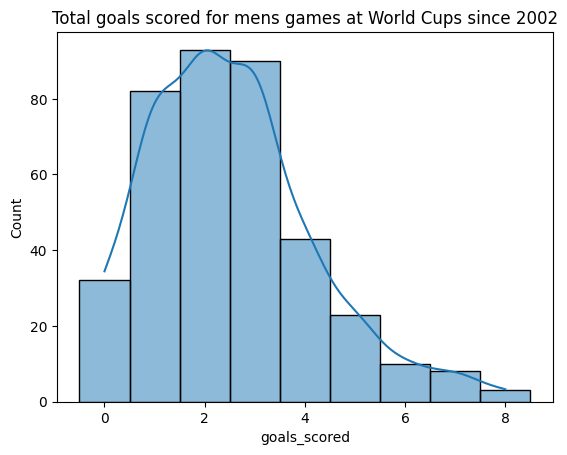

In [29]:
# Because the dataset contains home goals and away goals in separate columns, create a column called goals_scored
# First, create the column for men
men_results_since_2002["goals_scored"] = men_results_since_2002["home_score"] + men_results_since_2002["away_score"]
# Then, create a group for men
men_results_since_2002["group"] = "men"
# Then, create the column for women
women_results_since_2002["goals_scored"] = women_results_since_2002["home_score"] + women_results_since_2002["away_score"]
# And, the group for women
women_results_since_2002["group"] = "women"

# Now, because we are hypothesis testing, we need to know whether to use a parametric or nonparametric test. So, check whether the data are normally distributed or not
sns.histplot(data=men_results_since_2002, x='goals_scored', kde=True, discrete=True).set(title='Total goals scored for mens games at World Cups since 2002')

[Text(0.5, 1.0, 'Total goals scored for womens games at World Cups since 2002')]

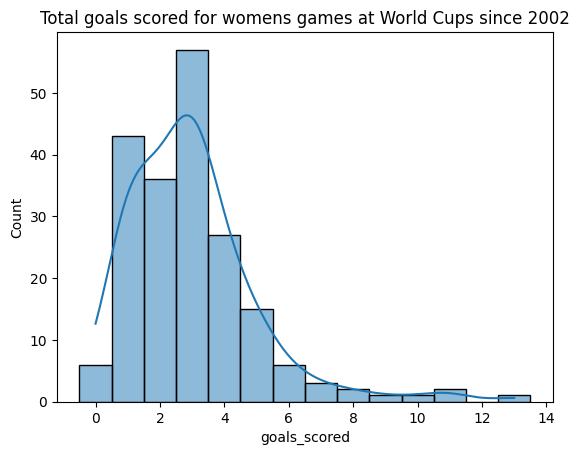

In [30]:
sns.histplot(data=women_results_since_2002, x='goals_scored', kde=True, discrete=True).set(title='Total goals scored for womens games at World Cups since 2002')

In [31]:
# Because the data are not normally distributed, we need a nonparametric test to compare the mean of two groups: the Wilcoxon-Mann-Whitney test 
# Therefore, import the appropriate package
from scipy.stats import mannwhitneyu

# Combine the women's and men's dataframes to calculate the total goals scored in each match
men_and_women_results_since_2002 = pd.concat([women_results_since_2002, men_results_since_2002], axis=0, ignore_index=True)

# Subset the new dataframe
men_and_women_results_since_2002subset = men_and_women_results_since_2002[["goals_scored", "group"]]

# Transform the data for the pingouin Wilcoxon-Mann-Whitney test
men_and_women_results_since_2002subsetwide = men_and_women_results_since_2002subset.pivot(columns="group", values="goals_scored")

# The alternative hypothesis (Ha) was that the mean number of goals scored in women's international soccer matches is GREATER than men's, therefore we need to use a right-tail;ed test.
# Perform right-tailed Wilcoxon-Mann-Whitney test with pingouin
Wilcoxon_Mann_Whitney_pg = pingouin.mwu(x=men_and_women_results_since_2002subsetwide["women"],
                          y=men_and_women_results_since_2002subsetwide["men"],
                          alternative="greater")
print(Wilcoxon_Mann_Whitney_pg)

       U-val alternative     p-val       RBC      CLES
MWU  43273.0     greater  0.005107 -0.126901  0.563451


In [32]:
# Alternative solution using SciPy: perform right-tailed Wilcoxon-Mann-Whitney test with scipy
Wilcoxon_Mann_Whitney_scipy = mannwhitneyu(x=women_results_since_2002["goals_scored"],
                             y=men_results_since_2002["goals_scored"],
                             alternative="greater")
print(Wilcoxon_Mann_Whitney_scipy)

MannwhitneyuResult(statistic=43273.0, pvalue=0.005106609825443641)


In [33]:
# The p-value and the result of the test must be stored in a dictionary called result_dict in the form:
# result_dict = {"p_val": p_val, "result": result}
# where p_val is the p-value and result is either the string "fail to reject" or "reject", depending on the result of the test.

# Extract p-value (from the pingouin approach) as a float
p_val = Wilcoxon_Mann_Whitney_pg["p-val"].values[0]

# Determine the hypothesis test result using a significance level of 10%
if p_val <= 0.1:
    result = "reject"
else:
    result = "fail to reject"

result_dict = {"p_val": p_val, "result": result}
print(result_dict)

{'p_val': 0.005106609825443641, 'result': 'reject'}


The p-value is less than 0.1 (10% level of significance) so we can reject the null hypothesis ($H_0$ ) that the mean number of goals scored in women's international soccer matches is the same as men's. 

Therefore, we can conclude that the mean number of goals scored in women's FIFA World Cup matches since 2002 is the not same as the mean number of goals scored men's FIFA World Cup matches since 2002.